**CSE 5522 Lab #1: Regression**



**Part 1: Multivariate regression (20 pts)**


**1.0:** We'll be looking at the Boston Housing dataset which is built in to sklearn, but has more variables. Load the dataset in:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
boston_dataset=load_boston()

boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV']=boston_dataset.target
boston.head()

CRIM    ZN  INDUS  CHAS    NOX  ...    TAX  PTRATIO       B  LSTAT  MEDV
0  0.00632  18.0   2.31   0.0  0.538  ...  296.0     15.3  396.90   4.98  24.0
1  0.02731   0.0   7.07   0.0  0.469  ...  242.0     17.8  396.90   9.14  21.6
2  0.02729   0.0   7.07   0.0  0.469  ...  242.0     17.8  392.83   4.03  34.7
3  0.03237   0.0   2.18   0.0  0.458  ...  222.0     18.7  394.63   2.94  33.4
4  0.06905   0.0   2.18   0.0  0.458  ...  222.0     18.7  396.90   5.33  36.2

[5 rows x 14 columns]

In [2]:
import seaborn as sb

correlation_matrix = boston.corr().round(2)
print(correlation_matrix['MEDV'])
plt.figure(figsize=(10,8))
sb.heatmap(data=correlation_matrix, annot=True, center=0.0, cmap='coolwarm')

CRIM      -0.39
ZN         0.36
INDUS     -0.48
CHAS       0.18
NOX       -0.43
RM         0.70
AGE       -0.38
DIS        0.25
RAD       -0.38
TAX       -0.47
PTRATIO   -0.51
B          0.33
LSTAT     -0.74
MEDV       1.00
Name: MEDV, dtype: float64


Note that the most correlated variable is LSTAT (at -0.74) and not RM (0.70) - while the correlation is negative, it just means that there is an inverse relationship between LSTAT and MEDV (when LSTAT goes up, MEDV goes down), but LSTAT should be the single best predictor.

**1.4:** Now, we kind of cheated there, since we figured out the correlation on the entire dataset.  A better practice is to randomly select training and test sets, fit the data on the training set, and then evaluate on the test set.  Let's see if LSTAT really is a better predictor than RM of MEDV.

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# first, set up dataframe for all variables 
boston_totaldata = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston_totaltarget = boston_dataset.target

boston_traindata, boston_testdata, boston_traintarget, boston_testtarget = train_test_split(boston_totaldata,
                                                                                           boston_totaltarget,
                                                                                           test_size=0.2,
                                                                                           random_state=5)

In [4]:
# subselect LSTAT data, train model
#   note the double square brackets - need 2-dimensional array to come out of selection
lstat_traindata=boston_traindata[['LSTAT']]
lstat_testdata=boston_testdata[['LSTAT']]
lin_model = LinearRegression()
lin_model.fit(lstat_traindata,boston_traintarget)

lstat_testpredict=lin_model.predict(lstat_testdata)
rmse = (np.sqrt(mean_squared_error(boston_testtarget,lstat_testpredict)))
r2 = r2_score(boston_testtarget,lstat_testpredict)
print('Test RMSE = {}, Test R2 = {}'.format(rmse,r2))

Test RMSE = 6.2307165730986815, Test R2 = 0.5041523728903132


*Note:* We do no normalizing here because sklearn will do it for us, if necessary

R2 is the amount of variation explained by the model, and can range from 0 (no variance explained) to 1 (perfect explanation). 

*Something for you to think about:* Notice that R2 is much lower than the correlation coefficient.  Why? (There are 2 reasons.)

**1.4a:** Let's do it again for RM (this time, you calculate it).

In [5]:
# subselect RM data, train model
rm_traindata=boston_traindata[['RM']]
rm_testdata=boston_testdata[['RM']]
lin_model2 = LinearRegression()
lin_model2.fit(rm_traindata,boston_traintarget)

rm_testpredict=lin_model2.predict(rm_testdata)
rmse = (np.sqrt(mean_squared_error(boston_testtarget,rm_testpredict)))
r2 = r2_score(boston_testtarget,rm_testpredict)
print('Test RMSE = {}, Test R2 = {}'.format(rmse,r2))

Test RMSE = 4.895963186952216, Test R2 = 0.6938399401553497


(Note: answers for why R2 is lower that correlation is that (a) it's roughly the square of correlation, and also (b) we calculated correlation on the entire training set; R2 was calculated on test only.)

**1.5:** At this point, you can start to look at how to predict from multiple variables.  What are the two best variables in predicting as measured by R2? (Try every possible variable pair.)

Are the results better than predicting using all variables?

In [6]:
import itertools
import bisect

# start by training and testing with all variables
lin_model = LinearRegression()
lin_model.fit(boston_traindata, boston_traintarget)
testpredict = lin_model.predict(boston_testdata)
rmse = (np.sqrt(mean_squared_error(boston_testtarget,testpredict)))
r2 = r2_score(boston_testtarget,testpredict)
print(f"Using all variables resulted in RMSE: {rmse} and r2: {r2}")


# list of (RMSE, r2, pair A, pair B)
ascending_rmse = []
# list of (r2, RMSE, pair A, pair B)
ascending_r2 = []

# iterate on list of all pair combinations
for a, b in list(itertools.combinations(boston_traindata.keys(),2)):

  # train model
  traindata = pd.concat([boston_traindata[[a]], boston_traindata[[b]]], axis=1)
  lin_model = LinearRegression()
  lin_model.fit(traindata,boston_traintarget)

  # test model
  testdata = pd.concat([boston_testdata[[a]], boston_testdata[[b]]], axis=1)
  testpredict = lin_model.predict(testdata)
  rmse = (np.sqrt(mean_squared_error(boston_testtarget,testpredict)))
  r2 = r2_score(boston_testtarget,testpredict)

  # insert results in order
  bisect.insort(ascending_rmse, (rmse, r2, a, b))
  bisect.insort(ascending_r2, (r2, rmse, a, b))

# print pair results
print(f"{len(ascending_rmse)} pair combinations yielded:")
rmse, r2, a, b = ascending_rmse[-1]
print(f"({a}, {b}) with the highest RMSE: {rmse} with r2: {r2}")
r2, rmse, a, b = ascending_r2[-1]
print(f"({a}, {b}) with the highest r2: {r2} with RMSE: {rmse}")



Using all variables resulted in RMSE: 4.568292042303217 and r2: 0.7334492147453064
78 pair combinations yielded:
(ZN, DIS) with the highest RMSE: 8.666885022431984 with r2: 0.0406030863577983
(RM, TAX) with the highest r2: 0.7499168993835434 with RMSE: 4.424926377335585


Using specific variables are better than using all variables.

---
---
**Part 2: Predicting Gene Expression (40 pts)**

There are ~20,000 genes in the human genome. Each one of them is transcribed to mRNA and then translated to proteins which carry on various tasks inside our body. We can measure the amount of 20,000 mRNA expressed in samples collected from different organs. This collection is called _gene expression profile_.

Although our genome is the same across all cell types, the gene expression profile is different because each organ needs different proteins for its survival. One of the regulatory mechanisms which controls the expression level in each cell type is microRNA (miR). MicroRNAs are small molecules which attach to mRNAs and prevent them from translation to proteins and also degrade them.

So if miR A targets mRNA B when A increases B decreases. Our goal is to predict mRNA levels (gene expression profile) using 21 miR features. Note that each of the 20,000 expression levels can be a response of regression with 21 features. To simplify, we have selected a few genes to predict their expression.

Your job will be to investigate how well the miR values predict the mRNA values.  

You are recommended to use the sklearn.linear_model package to conduct linear regression experiments, but you may use other packages if you wish.  

**Instructions:** Load the data from GitHub (example code given). 

**Hint:** Part 1 of this lab (Boston Housing) has examples of how to do almost everything you need for this part. Please review it carefully.

In [7]:
miR_URL='https://raw.githubusercontent.com/efosler/cse5522data/master/miRScore-x.csv'
miR_df=pd.read_csv(miR_URL)
# remove row names from the first column, rows=samples, cols=miR features
miR_labels = list(miR_df.columns)[1:]
miR = np.array(miR_df)[:,1:]

mRNA_well_URL='https://raw.githubusercontent.com/efosler/cse5522data/master/mRNA-y-well-explained.csv'
mRNA_well_df=pd.read_csv(mRNA_well_URL)
# remove label column, transpose with rows=samples, cols=mRNA
mRNA_well_labels = mRNA_well_df[mRNA_well_df.columns[0]].to_list()
mRNA_well = np.transpose(np.array(mRNA_well_df)[:,1:8896])

mRNA_poor_URL='https://raw.githubusercontent.com/efosler/cse5522data/master/mRNA-y-poor-explained.csv'
mRNA_poor_df=pd.read_csv(mRNA_poor_URL)
# remove label column, transpose with rows=samples, cols=mRNA
mRNA_poor_labels = mRNA_poor_df[mRNA_poor_df.columns[0]].to_list()
mRNA_poor = np.transpose(np.array(mRNA_poor_df)[:,1:8896])

print(f"\n   miR shape: {miR.shape}")
print(f"\n   mRNA_well shape: {mRNA_well.shape}")
print(f"\n   mRNA_poor shape: {mRNA_poor.shape}\n")



   miR shape: (8895, 21)

   mRNA_well shape: (8895, 35)

   mRNA_poor shape: (8895, 20)



You should randomly divide the samples into 80/20 training/test splits, and repeat the experiment 10 times to give mean and standard deviation of the metrics.

**2.1:** Using the *miR* features, predict each of the well-expressed (*mRNA_well*) and poorly-expressed (*mRNA_poor*) genes with a linear model. This means you will be solving 55 separate linear regression problems (one each for 35 well-expressed + 20 poorly expressed).

Perform 10 experiments of the above using a different training/test split each time. Report the the mean and standard deviation (over the 10 experiments) for each of the 55 mRNA targets for both the R2 and RMSE metrics.

*Note:* This means in total you will be building/training 550 different models!

In [8]:
# after transforms, put numpy arrays back into dataframes with column names

miR_df = pd.DataFrame(miR, columns=miR_labels)
mRNA_poor_df = pd.DataFrame(mRNA_poor, columns=mRNA_poor_labels)
mRNA_well_df = pd.DataFrame(mRNA_well, columns=mRNA_well_labels)

print(f"\n{miR_df.head()}")
print(f"\n\n\n{mRNA_poor_df.head()}")
print(f"\n\n\n{mRNA_well_df.head()}\n")



      MIRC1     MIRC2     MIRC3  ...    MIRC19    MIRC20    MIRC21
0  5.453767  4.383828  3.216983  ...  3.977328  5.501027  4.756962
1  4.321988  3.986583  3.829885  ...  4.199990  5.224254  4.429511
2  4.089116  4.178590  3.393789  ...  3.138479  5.682007  4.403253
3  4.884692  4.061140  3.475111  ...  4.542415  5.469924  4.693171
4  4.053976  4.224208  3.801616  ...  2.677879  5.577007  4.290140

[5 rows x 21 columns]



     NOBOX  SCGB1D4     RPL9   SPATA8  ...  SULT1C3    KRT38 TMPRSS12  C4orf11
0  3.32193  3.32193  7.55608  3.32193  ...  3.32193  3.32193  3.32193  3.32193
1  3.32193  3.32193  8.11135  3.32193  ...  3.32193  3.32193  3.32193  3.32193
2  3.32193  3.32193  8.29713  3.32193  ...  3.32193  3.32193  3.32193  3.32193
3  3.32193  3.32193  8.48298  3.32193  ...  3.32193  3.32193  3.32193  3.32193
4  3.32193  3.32193  11.7944  3.40039  ...  3.32193  3.32193  3.32193  3.32193

[5 rows x 20 columns]



  SNORD88B    GRHL2 C1orf172    RAB25  ... ATP6V1G2     ST14   SHISA7  

For calculation ease, I wanted to combine mRNA_well/poor. If my results seem odd this is a good place to check.


In [9]:
mRNA_poor_df.reset_index(drop=True, inplace=True)
mRNA_well_df.reset_index(drop=True, inplace=True)
mRNA_combined = pd.concat([mRNA_poor_df, mRNA_well_df], axis=1)
print(f" shape is {mRNA_combined.shape}")
mRNA_combined.head()

 shape is (8895, 55)


NOBOX  SCGB1D4     RPL9   SPATA8  ... ATP6V1G2     ST14   SHISA7     ELF3
0  3.32193  3.32193  7.55608  3.32193  ...  5.54788  6.20713  3.45425  3.57546
1  3.32193  3.32193  8.11135  3.32193  ...   4.2371   6.8108  3.58655  4.00356
2  3.32193  3.32193  8.29713  3.32193  ...  5.63511  5.81289  3.93852  4.36912
3  3.32193  3.32193  8.48298  3.32193  ...  6.45054  6.53732  4.53407  5.51195
4  3.32193  3.32193  11.7944  3.40039  ...  3.67743   6.0296  3.32193  3.54555

[5 rows x 55 columns]

In [10]:
results = {}

for _ in range(10):
  for gene in mRNA_combined:

    traindata, testdata, traintarget, testtarget = train_test_split(miR_df,
                                                                    mRNA_combined[gene],
                                                                    test_size=0.2)
    
    lin_model = LinearRegression()
    lin_model.fit(traindata, traintarget)
    testpredict = lin_model.predict(testdata)
    rmse = (np.sqrt(mean_squared_error(testtarget,testpredict)))
    r2 = r2_score(testtarget,testpredict)

    results.setdefault(gene, []).append((rmse, r2))

Seperate well expressed genes from poor expressed. Get mean and st
dev of their rmse and r2 values over the 10 trials.

In [11]:
import statistics as st

poor_results = {}
for gene in mRNA_poor_labels:
  rmse, r2 = zip(*results[gene])
  poor_results[gene] = (st.mean(r2), st.stdev(r2), st.mean(rmse), st.stdev(rmse))

well_results = {}
for gene in mRNA_well_labels:
  rmse, r2 = zip(*results[gene])
  well_results[gene] = (st.mean(r2), st.stdev(r2), st.mean(rmse), st.stdev(rmse))

**2.2:** Visualize and compare the performance of the well expressed gene set to the poorly expressed gene set using R2.  Draw histograms of the R2s for both sets on the same plot; one histogram comparison should be done for train and one for test. (matplotlib has builtin histogram-drawing functions, see the documentation.)

Describe the differences you see across the well and poorly expressed gene sets.

Self reminder: results stored in dictrionary of {gene name, (mean(r2), stdev(r2), mean(rmse), stdev(rmse))}

In [12]:
import math

# extract r2 mean values for all poorly and well expressed
r2_poor = [r2s[0] for r2s in poor_results.values()]
r2_well = [r2s[0] for r2s in well_results.values()]

# plot histograms
from matplotlib import pyplot

bins = 60

pyplot.hist(r2_poor, bins, label='poorly expressed')
pyplot.hist(r2_well, bins, label='well expressed')
pyplot.legend(loc='upper right')
pyplot.show()

As you can see, the r2 values for the poorly expressed mRNA are near zero. This means that our independent variables do not explain very much of the variance in our model regarding poorly expressed mRNA. As for the well-expressed, I am inclined to believe that they indicate that there's a strong relationship between my model and the dependent variable. That being said, r2 is a biased estimator that tends to be higher than it should. It is also subject to overfitting but I do not know how to determine that yet.

**2.3:** In this part, we want to add a categorical feature as the 22nd predictor. Tissue type is an important factor in explaining the gene expression profile. Our samples come from 32 tissue types which are provided to you in a separate file. Use dummy variable coding to include the tissue type in your regression.  

Recall that in dummy variable coding of categorical variable X with n levels, we add n - 1 columns to our features. The first level is coded as zero and then for each level, we set one of the columns to 1. For example, if we have a categorical feature for "Direction" with four levels "South, West, North, East" the following codes are required:

|                         | West | North | East |
|-------------------------|:----:|:-----:|:----:|
| Code if Direction=South |   0  |   0   |   0  |
| Code if Direction=West  |   1  |   0   |   0  |
| Code if Direction=North |   0  |   1   |   0  |
| Code if Direction=East  |   0  |   0   |   1  |

So for 32 values for the "Tissue" feature, you need to add 31 columns to your feature (design) matrix. With the newly added feature(s) run the linear regressions again with the 80/20 split and report any change in prediction performance of your model. Also, please *try* to find an explaination for any change in performance you see.

In [13]:
# Load tissue data
tissue_type_URL='https://github.com/efosler/cse5522data/raw/master/cancerType-x-Categorical.csv'
tissue_dataframe=pd.read_csv(tissue_type_URL)


# drop left column
tissue_df = tissue_dataframe.iloc[: , 1:]
print(tissue_df.head())

# get dummy variables
print(f"Shape before dummy transform: {tissue_df.shape}")
tissue_df = pd.get_dummies(tissue_df)
print(f"Shape after dummy transform: {tissue_df.shape}")

# combine miR wit dummy variables
miR_tissue = pd.concat([miR_df, tissue_df], axis=1)
miR_tissue.head()


  cancerType
0        ACC
1        ACC
2        ACC
3        ACC
4        ACC
Shape before dummy transform: (8895, 1)
Shape after dummy transform: (8895, 32)


MIRC1     MIRC2  ...  cancerType_UCS  cancerType_UVM
0  5.453767  4.383828  ...               0               0
1  4.321988  3.986583  ...               0               0
2  4.089116  4.178590  ...               0               0
3  4.884692  4.061140  ...               0               0
4  4.053976  4.224208  ...               0               0

[5 rows x 53 columns]

do everyting we did above, again

In [14]:
results = {}

for _ in range(10):
  for gene in mRNA_combined:

    traindata, testdata, traintarget, testtarget = train_test_split(miR_tissue,
                                                                    mRNA_combined[gene],
                                                                    test_size=0.2)
    
    lin_model3 = LinearRegression()
    lin_model3.fit(traindata, traintarget)
    testpredict = lin_model3.predict(testdata)
    rmse = (np.sqrt(mean_squared_error(testtarget,testpredict)))
    r2 = r2_score(testtarget,testpredict)

    results.setdefault(gene, []).append((rmse, r2))

In [15]:
well_results = {}
for gene in mRNA_well_labels:
  rmse, r2 = zip(*results[gene])
  well_results[gene] = (st.mean(r2), st.stdev(r2), st.mean(rmse), st.stdev(rmse))

poor_results = {}
for gene in mRNA_poor_labels:
  rmse, r2 = zip(*results[gene])
  poor_results[gene] = (st.mean(r2), st.stdev(r2), st.mean(rmse), st.stdev(rmse))

In [16]:
# extract r2 values for all poorly and well expressed
r2poor = [r2s[0] for r2s in poor_results.values()]
r2well = [r2s[0] for r2s in well_results.values()]

bins = 60

pyplot.hist(r2poor, bins, label='poorly expressed')
pyplot.hist(r2well, bins, label='well expressed')
pyplot.legend(loc='upper right')
pyplot.show()

My findings show tat microRNA is a poor predictor of poorly expressed genes irrespective of tissue type. microRNA is is a better predictor of well expressed genes (sorry for typos i ave to press "H" 10x to get it to work...) 

---
---

**Part 3: Logistic Regression (40 points)**

In this exercise, you will implement logistic regression by gradient descent.  You <u>should not</u> use off the shelf logistic regression solvers for this problem. (Though you may use them to check your work.) This will also exercise your data skills, so you may want to read up on the pandas toolkit.

Problem: you are given a dataset of 400 people; half female/half male, also half of the people are basketball players and half are not.   The data has three features: height (inches), weight (pounds), and female (0=male, 1=female).  The variable you want to predict is basketball player (0=non-player, 1=player).

In [17]:
basketball_URL='https://raw.githubusercontent.com/efosler/cse5522data/master/height_vs_weight.csv'
basketball_df=pd.read_csv(basketball_URL)
basketball_df.head()


height  weight  female  basketball
0    74.8   221.2       0           1
1    65.6   147.3       1           1
2    74.8   166.8       0           0
3    68.5   174.1       0           0
4    66.8   156.6       1           0

In [18]:
from sklearn import preprocessing 
import math                               

Implement gradient descent for logistic regression.  You may want to consult the notes in the regression model on logistic regression for help.

*Warning*: You may find it necessary to normalize the feature data, just like in first hands-on activity! However, unlike the hands-on, <u>do not</u> normalize the target data.

**3.1:** Train the model first to predict the probability of basketball given height.   




In [19]:
def computeMSEBatchGradientA(weights, features, targets):
  w0 = 0
  w1 = 0
  for n, x in enumerate(features):
    error = targets[n] - (weights[1] * x + weights[0])
    w0 -= error
    w1 -= x * error
  n += 1 
  w0 *= 2.0/n
  w1 *= 2.0/n
  return np.array([w0, w1])




def computeMSEBatchGradientB(weights, features, targets):
    predictions=features*weights[1]+weights[0]
    errors=targets-predictions
    gradient=np.array([-2.0*np.average(errors),-2.0*np.average(features*errors)])
    return gradient



def computeGradientDescentWeightUpdate(weights, features, targets, learning_rate):
  gradient=computeMSEBatchGradientB(weights,features,targets)
  weights = weights - learning_rate * gradient
  return weights




def get_final_weight(weights, 
                     features, 
                     target, 
                     learning_rate, 
                     iterations, 
                     report_freq):
  
  for step in range(iterations):
    weights = computeGradientDescentWeightUpdate(weights, features, target, learning_rate)
    
    if (step % report_freq == 0):
      print(f"{weights[1]:.6f}, {weights[0]:.6f}")
  print("==avg==============") 
  print(f"{weights[1]:.6f}, {weights[0]:.6f}")

  return weights




def average_loss(target, predictions):
  n = len(predictions)
  sum = 0
  adjustment = 0

  for i in range(n):
    notzero = (target[i]*predictions[i])+((1-target[i])*(1-predictions[i]))
    if notzero > 0:
      sum += math.log(notzero)
    else:
      adjustment += 1
  
  return -sum / (n-adjustment)




def predict(weights, x):
  y = np.array([])
  for height in x:
    y = np.append(y, final_weight[1]*height + final_weight[0])
  return y




def compute_accuracy(predictions, actual):
  matches = [(int(predictions[i]==actual[i])) for i in range(len(predictions))]
  return np.sum(matches)/len(predictions)




def display_results(avgLoss, accuracy, x, predictions):
  print(f'''
  Using height to predict basketball playing

    Average loss: {avgLoss:.4f}

        Accuracy: {accuracy:.4f}
  ''')

  bounds = np.max(x) - np.min(x)
  x_sig = np.arange(-bounds, bounds, 0.1)
  y_sig = [(1/(1 + np.exp(-x - np.mean(x_sig)))) for x in x_sig]
  y_bools = [int(predictions[i] > 0.5) for i in range(len(predictions))]
  x_sig += 70

  plt.plot(x, y_bools, 'o') 
  plt.xlabel("Height")
  plt.ylabel("Plays basketball")
  plt.plot(x_sig, y_sig)
  plt.show()

  return x_sig, y_sig

Train the model on 80% of the data, reserving 20% for the test set.



In [20]:
tr_data, t_data, tr_target, t_target = train_test_split(basketball_df,
                                                        basketball_df,
                                                        test_size = 0.2)

Train my model and compare coefficient and intercept with sklearn

In [21]:
final_weight = get_final_weight(weights=np.array([0, 0]), 
                                features=tr_data["height"].to_numpy(), 
                                target=tr_target["basketball"].to_numpy(),
                                learning_rate=0.0001, 
                                iterations=1000000, 
                                report_freq=100000)

print("==sk===============")
lin_model=LinearRegression()
lin_model.fit(tr_data[["height"]],tr_target[["basketball"]])
print(f"{lin_model.coef_[0][0]:.6f}, {lin_model.intercept_[0]:.6f}")

0.007082, 0.000099
0.010107, -0.202207
0.012684, -0.383089
0.014988, -0.544814
0.017048, -0.689411
0.018889, -0.818694
0.020536, -0.934284
0.022008, -1.037633
0.023325, -1.130036
0.024502, -1.212652
==avg==============
0.025554, -1.286518
==sk===============
0.034437, -1.910107


Make predictions using my model

In [22]:
x = t_data['height'].to_numpy()
predictions = predict(final_weight, x)

Compute the average loss on the test set: $$-\frac{1}{N}\sum_{i-1}^N\log\left(target_i\cdot P\left(prediction_i\right)\:+\:\left(1-target_i\right)\left(1-P\left(prediction_i\right)\right)\right)$$

(Note this is just a clever way to say use P(prediction) when target is 1, 1-P(prediction) when target is 0.)

In [23]:
avgLoss = average_loss(t_data['basketball'].to_numpy(), predictions)

Compute the accuracy on the test set by predicting someone is a basketball player if P(prediction) > 0.5.

In [24]:
accuracy = compute_accuracy(predictions, t_data['basketball'].to_numpy())

Plot the training data as well as the learned logistic regression function, on the same plot. (I'm looking for somthing similar to what is shown on Slide 29 of Week 2.)


  Using height to predict basketball playing

    Average loss: 0.6306

        Accuracy: 0.0000
  


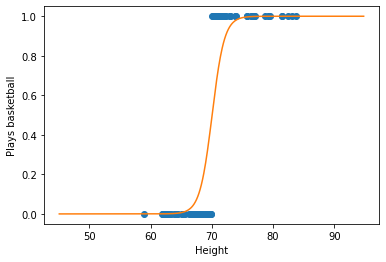

In [25]:
x_sig, y_sig = display_results(avgLoss, accuracy, x, predictions)

**3.2:**  Now train the model to be gender dependent by incorporating both the height and female features.  Evaluate on the same test set with average loss and accuracy.

Plot the logistic regression function across heights for male and female. (In other words, you will now plot two sigmoid curves, one for when gender=0, and one for when gender=1.)

Do the learned functions make sense relative to one another? Explain.

Gender specificity starting with female.

In [26]:
female_train = tr_data[tr_data['female'] == 1]
female_test = t_data[t_data['female'] == 1]

In [27]:
final_weight = get_final_weight(weights=np.array([0, 0]), 
                                features=female_train["height"].to_numpy(), 
                                target=female_train["basketball"].to_numpy(),
                                learning_rate=0.0001, 
                                iterations=1000000, 
                                report_freq=100000)

print("==sk===============")
lin_model=LinearRegression()
lin_model.fit(female_train[["height"]],female_train[["basketball"]])
print(f"{lin_model.coef_[0][0]:.6f}, {lin_model.intercept_[0]:.6f}")

0.006737, 0.000098
0.010266, -0.188115
0.012858, -0.362481
0.015258, -0.524010
0.017482, -0.673646
0.019543, -0.812266
0.021451, -0.940681
0.023219, -1.059641
0.024857, -1.169842
0.026375, -1.271931
==avg==============
0.027780, -1.366502
==sk===============
0.045467, -2.556480


In [28]:
x_f = female_test['height'].to_numpy()
predictions_f = predict(final_weight, x_f)

In [29]:
avgLoss_f = average_loss(female_test['basketball'].to_numpy(), predictions_f)

In [30]:
y_bools_f = [int(predictions_f[i] > 0.5) for i in range(len(predictions_f))]
accuracy_f = compute_accuracy(y_bools_f, female_test['basketball'].to_numpy())

In [31]:
x_sig_f, y_sig_f = display_results(avgLoss_f, accuracy_f, x_f, predictions_f)


  Using height to predict basketball playing

    Average loss: 0.6586

        Accuracy: 0.6286
  


Male only

In [32]:
male_train = tr_data[tr_data['female'] == 0]
male_test = t_data[t_data['female'] == 0]

In [33]:
final_weight = get_final_weight(weights=np.array([0, 0]), 
                                features=male_train["height"].to_numpy(), 
                                target=male_train["basketball"].to_numpy(),
                                learning_rate=0.0001, 
                                iterations=1000000, 
                                report_freq=100000)

print("==sk===============")
lin_model=LinearRegression()
lin_model.fit(male_train[["height"]],male_train[["basketball"]])
print(f"{lin_model.coef_[0][0]:.6f}, {lin_model.intercept_[0]:.6f}")

0.007449, 0.000099
0.010436, -0.250537
0.013603, -0.481865
0.016525, -0.695378
0.019223, -0.892447
0.021713, -1.074339
0.024011, -1.242222
0.026132, -1.397176
0.028089, -1.540196
0.029896, -1.672201
==avg==============
0.031564, -1.794039
==sk===============
0.051552, -3.254222


In [34]:
x_m = male_test['height'].to_numpy()
predictions_m = predict(final_weight, x_m)

In [35]:
avgLoss_m = average_loss(male_test['basketball'].to_numpy(), predictions_m)

In [36]:
y_bools_m = [int(predictions_m[i] > 0.5) for i in range(len(predictions_m))]
accuracy_m = compute_accuracy(y_bools_m, male_test['basketball'].to_numpy())


  Using height to predict basketball playing

    Average loss: 0.5737

        Accuracy: 0.7111
  


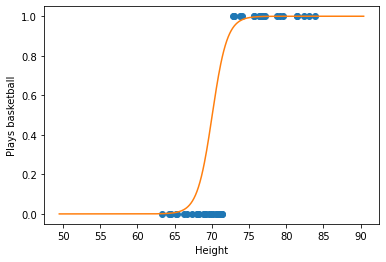

In [37]:
x_sig_m, y_sig_m = display_results(avgLoss_m, accuracy_m, x_m, predictions_m)

Compare

In [38]:
plt.plot(x_m, y_bools_m, 'o', label='male')
plt.plot(x_f, y_bools_f, 'x', label='female')
plt.plot(x_sig_m, y_sig_m, label='male')
plt.plot(x_sig_f, y_sig_f, label='female')
plt.xlabel("Height")
plt.ylabel("Plays basketball")
plt.legend(loc='lower right')
plt.show()